In [1]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2020.deeplearning/master/init.py
from init import init; init(force_download=False)

## Tipos de tareas de machine learning

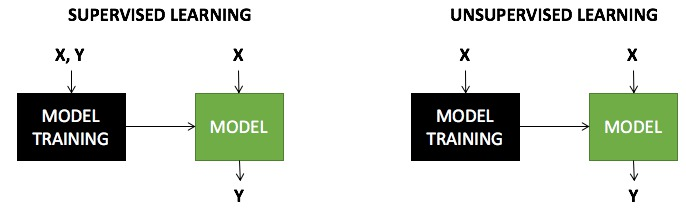

In [2]:
from IPython.display import Image
Image(filename='local/imgs/learning.jpg', width=800)

# Cómo se diseña un algoritmo ML

1. Elegir de qué parámetros depende una predicción $\rightarrow$ se define **cómo** es un modelo.
2. Definir una función que mida el error de la predicción.
3. Determinar qué valores de los parámetros minimizan el error de predicción.


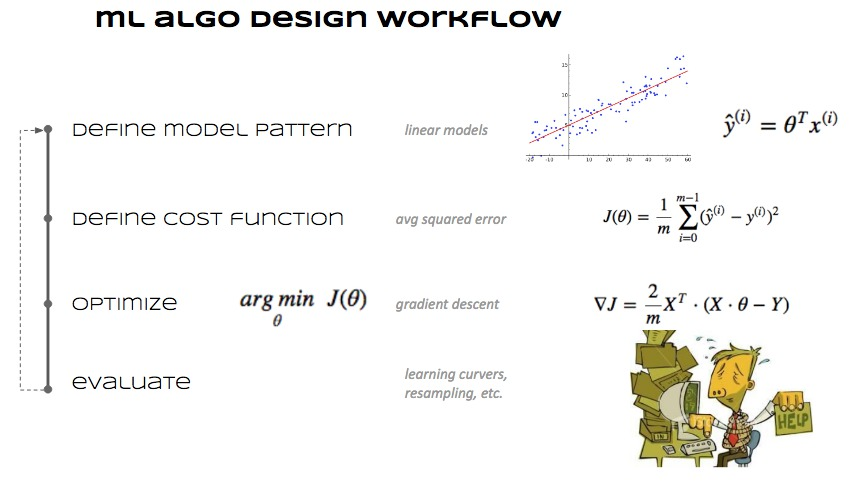

In [3]:
Image(filename='local/imgs/mldesign.jpg', width=800)

## Ejemplo

Los Trilotrópicos son insectos imaginarios que viven en las latitudes tropicales. Conocer su densidad de escamas es muy importante para poder saber qué insecticida aplicar. Pero **es muy costoso** contar las escamas.

Creemos que existe una relación entre la **longitud** y la **densidad de escamas** y queremos un modelo que prediga la densidad **a partir de la longitud**.

Esto es una tarea de regresión, ya que la predicción $\in \mathbb{R}$

Tenemos **datos anotados** (alguien contó las escamas de unos cuantos trilotrópicos) $\rightarrow$ estamos ante una tarea de **aprendizaje supervisado**

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
%matplotlib inline

(150, 2)


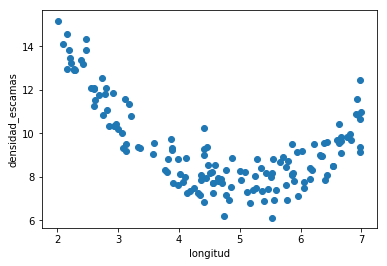

In [6]:
d = pd.read_csv("local/data/trilotropicos.csv")
print(d.shape)
plt.scatter(d.longitud, d.densidad_escamas)
plt.xlabel(d.columns[0])
plt.ylabel(d.columns[1]);

### 1. Elegimos la forma del modelo

**Entrada**
- $x^{(i)}$: longitud del trilotrópico $i$

**Salida esperada**
- $y^{(i)}$: densidad de escamas del trilotrópico $i$

**Predicción ** $\rightarrow$ decidimos que nuestro modelo tiene la siguiente forma

- $\hat{y}^{(i)} = \theta_0 + \theta_1 x^{(i)}$

La siguiente es una posible combinación de $\theta_0$ y $\theta_1$ seleccionada aleatoriamente. Ejecútalo varias veces para entender el error.

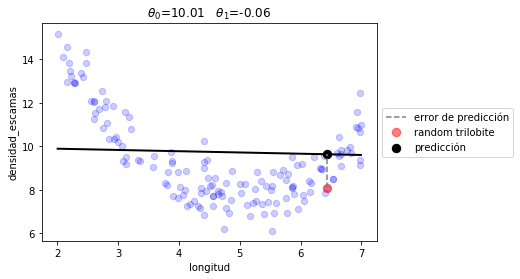

In [7]:
def linear_prediction(t, x):
    t0,t1 = t
    return t0 + t1*x

def plot_model(t, prediction):
    xr = np.linspace(np.min(d.longitud), np.max(d.longitud), 100)
    plt.scatter(d.longitud, d.densidad_escamas, s=40, alpha=.2, color="blue", label="")
    plt.plot(xr,prediction(t,xr), lw=2, color="black")
    plt.title("   ".join([r"$\theta_%d$=%.2f"%(i, t[i]) for i in range(len(t))]));

    p = d.iloc[np.random.randint(len(d))]
    pred = prediction(t, p.longitud)
    plt.plot([p.longitud, p.longitud], [p.densidad_escamas, pred], ls="--", color="gray", label=u"error de predicción")
    plt.scatter(p.longitud, p.densidad_escamas, s=70, alpha=.5, color="red", label="random trilobite")
    plt.scatter(p.longitud, pred, s=70, alpha=1., color="black", label=u"predicción")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.xlabel(d.columns[0])
    plt.ylabel(d.columns[1]);
    
t0 = np.random.random()*5+10
t1 = np.random.random()*4-3

plot_model([t0,t1], linear_prediction)

### 2. Definimos una medida de error

Para un dato cualquiera $(i)$
$$
\begin{align}
err^{(i)} &= (\hat{y}^{(i)}-y^{(i)})^2\\
&=(\theta_0 + \theta_1 x^{(i)} - y^{(i)})^2
\end{align}$$

Para todo el dataset

$$J(\theta_0, \theta_1) = \frac{1}{m} \sum_{i=0}^{m-1}(\theta_0 + \theta_1 x^{(i)} - y^{(i)})^2$$

si asumimos que

- $\overline{\theta} = [\theta_0, \theta_1]$
- $\mathbf{x}^{(i)} = [1, x^{(i)}]$

entonces podemos escribir de manera más compacta la expresión anterior:

$$J(\overline{\theta}) = \frac{1}{m} \sum_{i=0}^{m-1}(\overline{\theta} \dot \;  \mathbf{x}^{(i)} - y^{(i)})^2$$


In [8]:
def J(t, x, y, prediction):
    return np.mean( (prediction(t,x)-y)**2)
    

In [9]:
J([t0,t1], d.longitud, d.densidad_escamas, linear_prediction)

3.8236374780022038

### 3. Obtenemos los parámetros que minimizan el error de predicción

observa cómo usamos un **algoritmo genérico de optimización**

In [10]:
r1 = minimize(lambda t: J(t, d.longitud, d.densidad_escamas, linear_prediction), np.random.random(size=2))
r1

      fun: 2.7447662570807236
 hess_inv: array([[ 5.57436047, -1.09192024],
       [-1.09192024,  0.23444058]])
      jac: array([1.43051147e-06, 7.89761543e-06])
  message: 'Optimization terminated successfully.'
     nfev: 40
      nit: 9
     njev: 10
   status: 0
  success: True
        x: array([12.68999811, -0.71805893])

error total 2.74


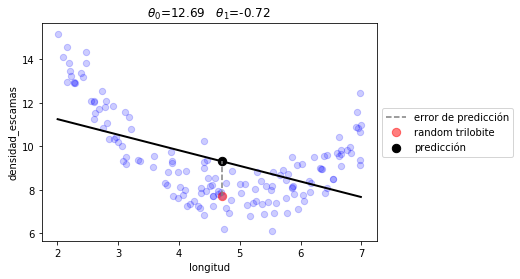

In [11]:
plot_model(r1.x, linear_prediction)
print("error total %.2f"%(J(r1.x, d.longitud, d.densidad_escamas, linear_prediction)))

fíjate que son los mismos valores que la regresión lineal clásica 

12.689998055222224 [-0.71805908]
error total 2.74


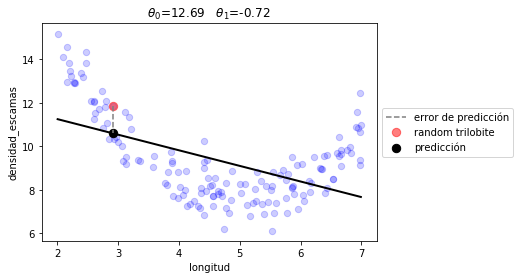

In [12]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(d.longitud.values.reshape(-1,1), d.densidad_escamas)
t0, t1 = lr.intercept_, lr.coef_
print(t0, t1)
plot_model([t0,t1], linear_prediction)
print("error total %.2f"%(J([t0, t1], d.longitud, d.densidad_escamas, linear_prediction)))

### Otra forma de modelo

esta vez con tres parámetros y un término **cuadrático**

$$\hat{y}^{(i)} = \theta_0 + \theta_1 x^{(i)} + \theta_2 (x^{(i)})^2$$


In [13]:
def quad_prediction(t, x):
    t0,t1,t2 = t
    return t0 + t1*x + t2*x**2

r2 = minimize(lambda t: J(t, d.longitud, d.densidad_escamas, quad_prediction), np.random.random(size=3))
r2

      fun: 0.553307673109007
 hess_inv: array([[ 50.73490871, -23.21576276,   2.42997093],
       [-23.21576276,  11.07369693,  -1.19047241],
       [  2.42997093,  -1.19047241,   0.13075262]])
      jac: array([-1.37835741e-06, -6.48200512e-07, -1.34855509e-06])
  message: 'Optimization terminated successfully.'
     nfev: 45
      nit: 4
     njev: 9
   status: 0
  success: True
        x: array([26.7587594 , -7.61051736,  0.75701628])

error total 0.55


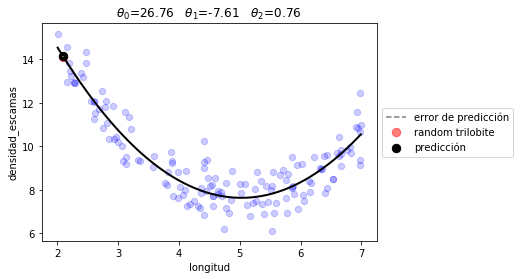

In [14]:
plot_model(r2.x, quad_prediction)
print("error total %.2f"%(J(r2.x, d.longitud, d.densidad_escamas, quad_prediction)))

observa como indirectamente hacemos lo mismo con la regresión lineal de `sklearn` añadiendo explícitamente una columna con la longitud al cuadrado

In [15]:
lr = LinearRegression()
lr.fit(np.r_[[d.longitud.values, d.longitud.values**2]].T, d.densidad_escamas)
t0, (t1, t2) = lr.intercept_, lr.coef_
t0, t1, t2

(26.75883713364987, -7.61055346692438, 0.7570201016172385)

# Tipología de algoritmos

- Generativos
- Discriminativos


# Abriendo la caja negra de la optimización

**EN ML, NO ES POSIBLE USAR ALGORITMOS DE OPTIMIZACIÓN TAN GENÉRICOS**, debido a:

- la complejidad de los modelos.
- la participación de los datos en las expresiones.

p.ej. ¿cuántos términos tiene la siguiente expresión?

$$J(\theta_0, \theta_1) = \frac{1}{m} \sum_{i=0}^{m-1}(\theta_0 + \theta_1 x^{(i)} - y^{(i)})^2$$

### 1. El gradiente

para que la optimización funcione en ML **es necesario** calcular el gradiente de la función de pérdida (el conjunto de derivadas parciales). Observa [aquí](https://matthewebmckenna.com/posts/2017/05/gradient-descent-linear-regression) la derivación matemática del gradiente para el caso de regresión lineal (que en realidad es el más sencillo).

Usamos la notación vectorial: $\theta = [\theta_0, \theta_1]$, $X = [ [1, x^{(i)}] ]^m \in \mathbb{R}^{m\times 2}$ y la función de pérdida queda como:

$$J(\theta) = \text{mean}(\mathbf{X}\theta-\mathbf{y})^2$$

y el gradiente

$$\nabla J = \begin{bmatrix}
\frac{\partial J}{\partial \theta_0}\\
\frac{\partial J}{\partial \theta_1}
\end{bmatrix} = \frac{1}{m}2X^{T}\cdot(X\cdot\theta-Y)$$

Observa ahora que cuando usamos el gradiente la minimización es mucho más eficiente (número de evaluaciones `nfev`) .

**EN ML, SIN EL GRADIENTE LA OPTIMIZACIÓN NO ES POSIBLE**

In [16]:
g = []

init_t = np.random.random()*40-5, np.random.random()*20-10

y = d.densidad_escamas.values
X = np.r_[[[1]*len(d), d.longitud.values]].T

def n_cost(t):
    return np.mean((X.dot(t)-y)**2)

def n_grad(t):
    return 2*X.T.dot(X.dot(t)-y)/len(X)

print("sin usar el gradiente")
r = minimize(n_cost, init_t, method="BFGS")
print(r)

print("\n usando el gradiente")
r = minimize(n_cost, init_t, method="BFGS", jac=n_grad)
print(r)

sin usar el gradiente
      fun: 2.7447662570801983
 hess_inv: array([[ 5.57513794, -1.0914388 ],
       [-1.0914388 ,  0.23472045]])
      jac: array([-2.98023224e-07, -3.57627869e-07])
  message: 'Optimization terminated successfully.'
     nfev: 24
      nit: 4
     njev: 6
   status: 0
  success: True
        x: array([12.68999713, -0.71805891])

 usando el gradiente
      fun: 2.744766257080116
 hess_inv: array([[ 5.57513616, -1.09143846],
       [-1.09143846,  0.23472038]])
      jac: array([9.11863178e-16, 4.21588690e-15])
  message: 'Optimization terminated successfully.'
     nfev: 6
      nit: 4
     njev: 6
   status: 0
  success: True
        x: array([12.68999806, -0.71805908])


observa el mapa del coste respecto a todos los posibles valores de $\theta_0$ y $\theta_1$ en el caso de un modelo lineal.

en blanco **los valores óptimos**

### 2. la optimización como proceso iterativo

fíjate cómo la optimización busca un camino en el espacio de parámetros para llegar al mínimo.

In [17]:
import itertools
def plot_cost(cost, t0_range, t1_range, vx=None,vy=None):
    k0,k1 = 40,40

    t0 = np.linspace(t0_range[0], t0_range[1], k0)
    t1 = np.linspace(t1_range[0], t1_range[1], k1)

    p = np.zeros((k0,k1))

    for i,j in itertools.product(range(k0), range(k1)):
        p[i,j] = np.log(cost(np.r_[t0[i],t1[j]]))

    plt.contourf(t0, t1, p.T, cmap=plt.cm.hot, levels=np.linspace(np.min(p), np.max(p), 20))
    plt.ylabel(r"$\theta_1$")
    plt.xlabel(r"$\theta_0$")
    plt.title("loss")
    plt.colorbar()

    if vx is not None:
        plt.axvline(vx, color="white")
    if vy is not None:
        plt.axhline(vy, color="white")
    

In [18]:
g = []
loss_history = []
def log(xk):
    loss_history.append(loss(xk))
    g.append(xk)

init_t = np.random.random()*40-5, np.random.random()*20-10

loss = lambda t: J(t, d.longitud, d.densidad_escamas, linear_prediction)


r = minimize(loss, init_t, callback=log, method="BFGS")
r

      fun: 2.7447662570833065
 hess_inv: array([[ 5.55369234, -1.0871943 ],
       [-1.0871943 ,  0.23388037]])
      jac: array([ 9.53674316e-07, -4.47034836e-07])
  message: 'Optimization terminated successfully.'
     nfev: 40
      nit: 9
     njev: 10
   status: 0
  success: True
        x: array([12.69000401, -0.71806026])

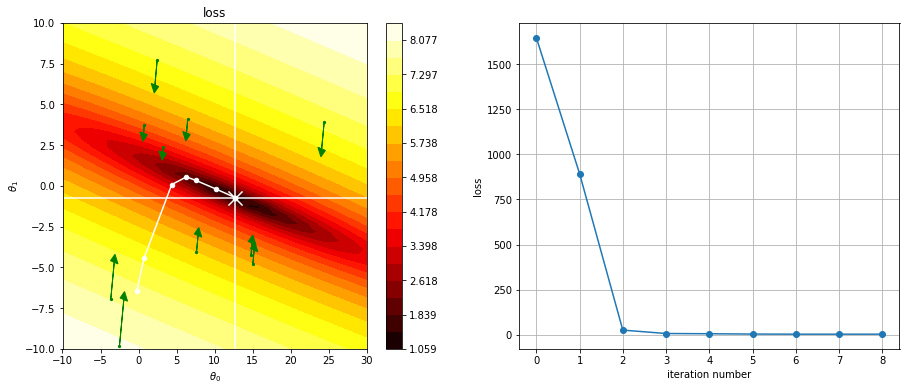

In [19]:
plt.figure(figsize=(15,6))
plt.subplot(121)
plot_cost(loss, (-10,30), (-10,10), vx=r1.x[0], vy=r1.x[1])
g = np.r_[g]
plt.plot(g[:,0], g[:,1], color="white")
plt.scatter(g[:,0], g[:,1], color="white", s=20)
plt.scatter(g[-1,0], g[-1,1], marker="x", color="white", s=200)

# plot gradient at some points
for _ in range(10):
    t = np.random.random()*30-5, np.random.random()*20-10
    grad = n_grad(t)
    grad = grad/200
    plt.scatter(t[0],t[1], c="green", s=5)
    plt.arrow(t[0], t[1], -grad[0], -grad[1], head_width=1, head_length=0.5, fc='green', ec='green')

plt.subplot(122)
plt.plot(loss_history, marker="o")
plt.xlabel("iteration number")
plt.ylabel("loss")
plt.grid()